In [1]:
# pip install keras-tcn
# pip install -U scikit-learn scipy matplotlib
# pip install tqdm
# pip install seaborn
# pip install -U imbalanced-learn
# !pip install tld
# !pip install googlesearch-python
# pip install tensorflow-hub

In [1]:
import tensorflow as tf
import keras
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.utils import to_categorical
from keras import losses
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Input, Embedding, LSTM, Flatten, Conv1D, Activation, UpSampling1D, MaxPooling1D, ZeroPadding1D
from keras.preprocessing import sequence
from tensorflow.keras.utils import plot_model
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from tcn import TCN, tcn_full_summary

import sys
from tqdm import tqdm
import os
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
urldata = pd.read_csv(r"C:\Users\LibraryUser\Desktop\Code\urldata.csv")
urldata.head()

,Unnamed: 0,url,label,result
0,0,https://www.google.com,benign,0
1,1,https://www.youtube.com,benign,0
2,2,https://www.facebook.com,benign,0
3,3,https://www.baidu.com,benign,0
4,4,https://www.wikipedia.org,benign,0


In [3]:
urldata = urldata.drop('Unnamed: 0',axis=1)

In [4]:
urldata.head()

,url,label,result
0,https://www.google.com,benign,0
1,https://www.youtube.com,benign,0
2,https://www.facebook.com,benign,0
3,https://www.baidu.com,benign,0
4,https://www.wikipedia.org,benign,0


In [5]:
urldata.shape

(450176, 3)

In [6]:
urldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450176 entries, 0 to 450175
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     450176 non-null  object
 1   label   450176 non-null  object
 2   result  450176 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 10.3+ MB


In [7]:
urldata.isnull().sum()

url       0
label     0
result    0
dtype: int64

In [8]:
urldata.label.value_counts()

label
benign       345738
malicious    104438
Name: count, dtype: int64

In [9]:
from urllib.parse import urlparse
from tld import get_tld
import os.path

In [10]:
import re
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
         '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}' # IPv6
        , url)
    return -1 if match else 1    # Match Found     - 1
                                # Match Not Found - 0

urldata['use_of_ip'] = urldata['url'].apply(lambda i : having_ip_address(i))

urldata.head()

,url,label,result,use_of_ip
0,https://www.google.com,benign,0,1
1,https://www.youtube.com,benign,0,1
2,https://www.facebook.com,benign,0,1
3,https://www.baidu.com,benign,0,1
4,https://www.wikipedia.org,benign,0,1


In [11]:
from googlesearch import search
def is_google_indexed(url):
    site = search(url, 5)
    return 1 if site else 0

urldata['google_index'] = urldata['url'].apply(lambda i : is_google_indexed(i))

urldata.head()

,url,label,result,use_of_ip,google_index
0,https://www.google.com,benign,0,1,1
1,https://www.youtube.com,benign,0,1,1
2,https://www.facebook.com,benign,0,1,1
3,https://www.baidu.com,benign,0,1,1
4,https://www.wikipedia.org,benign,0,1,1


In [12]:
def is_shortened(url):
    match = re.search(
        'bit.ly|goo.gl|shorte.st|go2l.ink|x.co|ow.ly|t.co|tinyurl|tr.im|is.gd|cli.gs|'
        'yfrog.com|migre.me|ff.im|tiny.cc|url4.eu|twit.ac|su.pr|twurl.nl|snipurl.com|'
        'short.to|BudURL.com|ping.fm|post.ly|Just.as|bkite.com|snipr.com|fic.kr|loopt.us|'
        'doiop.com|short.ie|kl.am|wp.me|rubyurl.com|om.ly|to.ly|bit.do|t.co|lnkd.in|'
        'db.tt|qr.ae|adf.ly|goo.gl|bitly.com|cur.lv|tinyurl.com|ow.ly|bit.ly|ity.im|'
        'q.gs|is.gd|po.st|bc.vc|twitthis.com|u.to|j.mp|buzurl.com|cutt.us|u.bb|yourls.org|'
        'x.co|prettylinkpro.com|scrnch.me|filoops.info|vzturl.com|qr.net|1url.com|tweez.me|v.gd|'
        'tr.im|link.zip.net'
        , url )
    return -1 if match else 1

urldata['short_url'] = urldata['url'].apply(lambda i : is_shortened(i))

urldata.head()

,url,label,result,use_of_ip,google_index,short_url
0,https://www.google.com,benign,0,1,1,1
1,https://www.youtube.com,benign,0,1,1,1
2,https://www.facebook.com,benign,0,1,1,1
3,https://www.baidu.com,benign,0,1,1,1
4,https://www.wikipedia.org,benign,0,1,1,1


In [13]:
def is_suspecious(url):
    match = re.search(
        'PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr'
        , url)
    
    return -1 if match else 1

urldata['sus_url'] = urldata['url'].apply(lambda i : is_suspecious(i))

urldata.head()

,url,label,result,use_of_ip,google_index,short_url,sus_url
0,https://www.google.com,benign,0,1,1,1,1
1,https://www.youtube.com,benign,0,1,1,1,1
2,https://www.facebook.com,benign,0,1,1,1,1
3,https://www.baidu.com,benign,0,1,1,1,1
4,https://www.wikipedia.org,benign,0,1,1,1,1


In [14]:
def url_length(url):
    return len(str(url))

urldata['url_len'] = urldata['url'].apply(lambda i : url_length(i))

urldata.head()

,url,label,result,use_of_ip,google_index,short_url,sus_url,url_len
0,https://www.google.com,benign,0,1,1,1,1,22
1,https://www.youtube.com,benign,0,1,1,1,1,23
2,https://www.facebook.com,benign,0,1,1,1,1,24
3,https://www.baidu.com,benign,0,1,1,1,1,21
4,https://www.wikipedia.org,benign,0,1,1,1,1,25


In [15]:
def hostname_length(url):
    try:
        return len(urlparse(url).netloc)
    except:
        return 0

urldata['hostname_len'] = urldata['url'].apply(lambda i : hostname_length(i))

urldata.head()

,url,label,result,use_of_ip,google_index,short_url,sus_url,url_len,hostname_len
0,https://www.google.com,benign,0,1,1,1,1,22,14
1,https://www.youtube.com,benign,0,1,1,1,1,23,15
2,https://www.facebook.com,benign,0,1,1,1,1,24,16
3,https://www.baidu.com,benign,0,1,1,1,1,21,13
4,https://www.wikipedia.org,benign,0,1,1,1,1,25,17


In [16]:
def path_length(url):
    try:
        return len(urlparse(url).path)
    except:
        return 0

urldata['path_len'] = urldata['url'].apply(lambda i : path_length(i))

urldata.head()

,url,label,result,use_of_ip,google_index,short_url,sus_url,url_len,hostname_len,path_len
0,https://www.google.com,benign,0,1,1,1,1,22,14,0
1,https://www.youtube.com,benign,0,1,1,1,1,23,15,0
2,https://www.facebook.com,benign,0,1,1,1,1,24,16,0
3,https://www.baidu.com,benign,0,1,1,1,1,21,13,0
4,https://www.wikipedia.org,benign,0,1,1,1,1,25,17,0


In [17]:
def firstDirectory_length(url):
    try:
        url_path = urlparse(url).path
        return len(url_path.split('/')[1])
    except:
        return 0

urldata['fd_len'] = urldata['url'].apply(lambda i : firstDirectory_length(i))

urldata.head()

,url,label,result,use_of_ip,google_index,short_url,sus_url,url_len,hostname_len,path_len,fd_len
0,https://www.google.com,benign,0,1,1,1,1,22,14,0,0
1,https://www.youtube.com,benign,0,1,1,1,1,23,15,0,0
2,https://www.facebook.com,benign,0,1,1,1,1,24,16,0,0
3,https://www.baidu.com,benign,0,1,1,1,1,21,13,0,0
4,https://www.wikipedia.org,benign,0,1,1,1,1,25,17,0,0


In [18]:
from tld import get_tld
def TLDLength(url):
    tld = get_tld(url, fail_silently = True)
    try:
        return len(str(tld))
    except:
        return -1

urldata['tld_len'] = urldata['url'].apply(lambda i : TLDLength(i))

urldata.head()

,url,label,result,use_of_ip,google_index,short_url,sus_url,url_len,hostname_len,path_len,fd_len,tld_len
0,https://www.google.com,benign,0,1,1,1,1,22,14,0,0,3
1,https://www.youtube.com,benign,0,1,1,1,1,23,15,0,0,3
2,https://www.facebook.com,benign,0,1,1,1,1,24,16,0,0,3
3,https://www.baidu.com,benign,0,1,1,1,1,21,13,0,0,3
4,https://www.wikipedia.org,benign,0,1,1,1,1,25,17,0,0,3


In [19]:
def count_hyphen(url):
    return url.count('-')

urldata['count-'] = urldata['url'].apply(lambda i : count_hyphen(i))

def count_atTheRate(url):
    return url.count('@')

urldata['count@'] = urldata['url'].apply(lambda i : count_atTheRate(i))

def count_ques(url):
    return url.count('?')

urldata['count?'] = urldata['url'].apply(lambda i : count_ques(i))

def count_spaces(url):
    return url.count('%')

urldata['count%'] = urldata['url'].apply(lambda i : count_spaces(i))

def count_dot(url):
    return url.count('.')

urldata['count.'] = urldata['url'].apply(lambda i : count_dot(i))

def count_equal(url):
    return url.count('=')

urldata['count='] = urldata['url'].apply(lambda i : count_equal(i))

def count_directories(url):
    return url.count('/')

urldata['count/'] = urldata['url'].apply(lambda i : count_directories(i))

def count_embeddings(url):
    return url.count('//')

urldata['count//'] = urldata['url'].apply(lambda i : count_embeddings(i))

def count_http(url):
    return url.count('http')

urldata['count-http'] = urldata['url'].apply(lambda i : count_http(i))

def count_https(url):
    return url.count('https')

urldata['count-https'] = urldata['url'].apply(lambda i : count_https(i))

def count_www(url):
    return url.count('www')

urldata['count-www'] = urldata['url'].apply(lambda i : count_www(i))

def count_digits(url):
    dc = 0
    for i in url:
        dc += 1 if i.isnumeric() else 0
    return dc

urldata['count-digits'] = urldata['url'].apply(lambda i : count_digits(i))

def count_letters(url):
    lc = 0
    for i in url:
        lc += 1 if i.isalpha() else 0
    return lc

urldata['count-letters'] = urldata['url'].apply(lambda i : count_letters(i))

print(urldata.head())

                         url   label  result  use_of_ip  google_index  \
0     https://www.google.com  benign       0          1             1   
1    https://www.youtube.com  benign       0          1             1   
2   https://www.facebook.com  benign       0          1             1   
3      https://www.baidu.com  benign       0          1             1   
4  https://www.wikipedia.org  benign       0          1             1   

   short_url  sus_url  url_len  hostname_len  path_len  ...  count%  count.  \
0          1        1       22            14         0  ...       0       2   
1          1        1       23            15         0  ...       0       2   
2          1        1       24            16         0  ...       0       2   
3          1        1       21            13         0  ...       0       2   
4          1        1       25            17         0  ...       0       2   

   count=  count/  count//  count-http  count-https  count-www  count-digits  \
0     

In [20]:
urldata['result'].value_counts()

result
0    345738
1    104438
Name: count, dtype: int64

In [21]:
urldata.columns

Index(['url', 'label', 'result', 'use_of_ip', 'google_index', 'short_url',
       'sus_url', 'url_len', 'hostname_len', 'path_len', 'fd_len', 'tld_len',
       'count-', 'count@', 'count?', 'count%', 'count.', 'count=', 'count/',
       'count//', 'count-http', 'count-https', 'count-www', 'count-digits',
       'count-letters'],
      dtype='object')

In [22]:
# Predictable Vector.

# Removed google_index since all the URLs have one.

x = urldata[['use_of_ip', 'short_url', 'sus_url', 'url_len', 'count-letters', 
             'hostname_len', 'path_len', 'fd_len', 'tld_len', 'count-', 
             'count@', 'count?', 'count%', 'count.', 'count=', 'count/',
             'count//', 'count-http', 'count-https', 'count-www', 'count-digits']
           ]

y = urldata['result']              # Target Variable.

print(x.head())
print(y.head())

   use_of_ip  short_url  sus_url  url_len  count-letters  hostname_len  \
0          1          1        1       22             17            14   
1          1          1        1       23             18            15   
2          1          1        1       24             19            16   
3          1          1        1       21             16            13   
4          1          1        1       25             20            17   

   path_len  fd_len  tld_len  count-  ...  count?  count%  count.  count=  \
0         0       0        3       0  ...       0       0       2       0   
1         0       0        3       0  ...       0       0       2       0   
2         0       0        3       0  ...       0       0       2       0   
3         0       0        3       0  ...       0       0       2       0   
4         0       0        3       0  ...       0       0       2       0   

   count/  count//  count-http  count-https  count-www  count-digits  
0       2        1   

*********************************** *No need to execute cells from here till In [75] (Until Confusion matrix) * *************************
                     The model is already included in zip file.

In [24]:
import imblearn
from imblearn.over_sampling import SMOTE

In [25]:
X, Y = SMOTE(sampling_strategy = 'all').fit_resample(x, y)

In [26]:
X = pd.DataFrame(X) 
Y = pd.DataFrame(Y)
print(X.shape, Y.shape)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(691476, 21) (691476, 1)


((553180, 21), (138296, 21), (553180, 1), (138296, 1))

In [27]:
x_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)
# print(x_test.shape)
input_shape = (x_train.shape[1], 1)
print(input_shape)

(21, 1)


In [28]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(x_train, x_test)
print(y_train, y_test)

[[[ 1]
  [ 1]
  [ 1]
  ...
  [ 1]
  [ 1]
  [ 2]]

 [[ 1]
  [ 1]
  [ 0]
  ...
  [ 0]
  [ 0]
  [ 0]]

 [[ 1]
  [ 1]
  [ 1]
  ...
  [ 0]
  [ 0]
  [ 2]]

 ...

 [[ 1]
  [ 1]
  [-1]
  ...
  [ 0]
  [ 0]
  [21]]

 [[ 1]
  [ 1]
  [ 1]
  ...
  [ 0]
  [ 0]
  [ 0]]

 [[ 1]
  [ 1]
  [ 1]
  ...
  [ 1]
  [ 1]
  [ 0]]] [[[ 1]
  [-1]
  [ 1]
  ...
  [ 0]
  [ 0]
  [19]]

 [[ 1]
  [ 1]
  [ 1]
  ...
  [ 0]
  [ 0]
  [ 0]]

 [[ 1]
  [ 1]
  [ 1]
  ...
  [ 1]
  [ 1]
  [ 5]]

 ...

 [[ 1]
  [ 1]
  [ 1]
  ...
  [ 1]
  [ 1]
  [ 0]]

 [[ 1]
  [ 1]
  [ 1]
  ...
  [ 0]
  [ 0]
  [ 2]]

 [[ 1]
  [ 1]
  [ 1]
  ...
  [ 1]
  [ 1]
  [ 4]]]
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]] [[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [29]:

print("Shapes:\nx_train:%s\ny_train:%s\n" % (x_train.shape, y_train.shape))
print("x_test:%s\ny_test:%s\n" % (x_test.shape, y_test.shape))
print("input_shape:{}\n".format(input_shape))

Shapes:
x_train:(553180, 21, 1)
y_train:(553180, 2)

x_test:(138296, 21, 1)
y_test:(138296, 2)

input_shape:(21, 1)



In [30]:
input_layer = Input(shape = (input_shape))
batch_size, time_steps, input_dim = None, 21, 1

tcn_layer = TCN(input_shape = (time_steps, input_dim))
model = Sequential([
    tcn_layer,
    Dense(2, activation = 'softmax')
])

model.summary()

model.compile(loss = "binary_crossentropy",
             optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
             metrics = ['accuracy'])

C:\Users\LibraryUser\AppData\Local\Programs\Python\Python312\Lib\site-packages\tcn\tcn.py:227: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ tcn (TCN)                            │ (None, 64)                  │          91,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,266 (356.51 KB)

 Trainable params: 91,266 (356.51 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint('model.keras', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [32]:
history = model.fit(x_train, y_train,
                   batch_size = 256,
                   epochs = 5,
                   verbose = 1,
                   validation_data = (x_test, y_test),
                   callbacks = [checkpointer])

Epoch 1/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9215 - loss: 0.4338
Epoch 1: val_accuracy improved from -inf to 0.99262, saving model to model.keras
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 248s 110ms/step - accuracy: 0.9215 - loss: 0.4337 - val_accuracy: 0.9926 - val_loss: 0.0400
Epoch 2/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9926 - loss: 0.0434
Epoch 2: val_accuracy improved from 0.99262 to 0.99651, saving model to model.keras
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 299s 127ms/step - accuracy: 0.9926 - loss: 0.0434 - val_accuracy: 0.9965 - val_loss: 0.0221
Epoch 3/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9959 - loss: 0.0311
Epoch 3: val_accuracy did not improve from 0.99651
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 397s 183ms/step - accuracy: 0.9959 - loss: 0.0311 - val_accuracy: 0.9947 - val_loss: 0.0430
Epoch 4/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9960 - loss: 0.0365
Epoch 4: val_accuracy did not improve from 0.99651
2161/216

In [33]:
model.save('n_model.keras')  # Model already included in Zip file.

In [34]:
score = model.evaluate(x_test, y_test, verbose = 1)
print("Test Loss :", score[0])
print("Test Accuracy : ", score[1])

4322/4322 ━━━━━━━━━━━━━━━━━━━━ 65s 15ms/step - accuracy: 0.9972 - loss: 0.0206
Test Loss : 0.020731303840875626
Test Accuracy :  0.9971655011177063


In [35]:
pred_test = model.predict(x_test)

4322/4322 ━━━━━━━━━━━━━━━━━━━━ 63s 14ms/step


In [36]:
print(pred_test)

[[0.0000000e+00 1.0000000e+00]
 [2.5738012e-25 1.0000000e+00]
 [1.0000000e+00 3.1503078e-09]
 ...
 [1.0000000e+00 5.2850186e-09]
 [7.6710830e-20 1.0000000e+00]
 [1.0000000e+00 2.5751659e-10]]


In [37]:
y_pred = np.round(pred_test)
print(y_pred)
auc = roc_auc_score(y_pred, y_test)    # Area under the row of curvature (roc).
print("AUC : {:.2%}".format(auc))

[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]
AUC : 99.72%


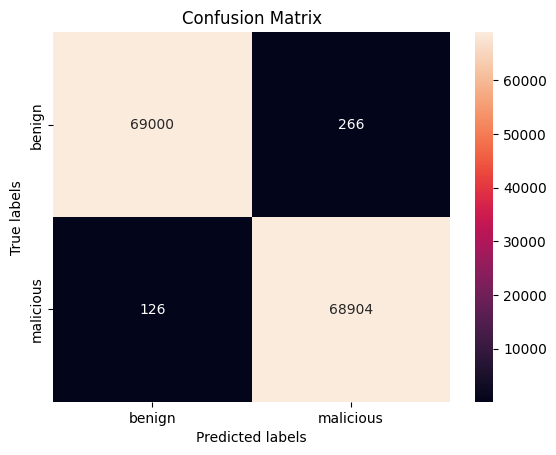

In [38]:
y_predict = np.argmax(y_pred, axis = -1)
y = np.argmax(y_test, axis = -1)
cnf_mat = confusion_matrix(y_predict, y)
ax= plt.subplot()
sns.heatmap(cnf_mat, annot=True, ax = ax, fmt="d");
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['benign','malicious']);
ax.yaxis.set_ticklabels(['benign','malicious']);

******************************** Till Here *****************************************

In [23]:
def main(url):
    
    status = []
    
    status.append(hostname_length(url))
    status.append(path_length(url))
    status.append(firstDirectory_length(url))
    status.append(TLDLength(url))
    
    status.append(url_length(url))
    status.append(count_hyphen(url))
    status.append(count_atTheRate(url))
    status.append(count_ques(url))
    status.append(count_spaces(url))
    status.append(count_dot(url))
    status.append(count_equal(url))
    status.append(count_directories(url))
    status.append(count_embeddings(url))
    status.append(count_http(url))
    status.append(count_https(url))
    status.append(count_www(url))
    status.append(count_digits(url))
    status.append(count_letters(url))
    
    status.append(having_ip_address(url))
    status.append(is_shortened(url))
    status.append(is_suspecious(url)) 
    
    return status

In [24]:
from tcn import TCN, tcn_full_summary
def get_prediction_for_url(test_url):
    features_test = main(test_url)
    features_test = np.array(features_test).reshape((1, -1))
    # print(features_test)
    # pr = model.predict(features_test)
    m = tensorflow.keras.models.load_model('n_model.keras')
    pred_ans = m.predict(features_test)
    print(pred_ans)
    if pred_ans[0][0] == 0 : return 'Benign'
    else : return 'Malware'

In [25]:
import tensorflow_hub as hub
import tensorflow_hub as hub
import tensorflow as tf
from tcn import TCN, tcn_full_summary
import tensorflow.keras
import tensorflow.keras.models

urls = ['http://ecct-it.com/docmmmnn/aptgd/index.php', 
        'http://deoppe.ml/partition/intenery/', 
        'https://www.spelldown.ifmerch.com/en/', 
        'http://d233870.u-telcom.net/qa/']
for i in urls:
     print(get_prediction_for_url(i))



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[0. 1.]]
Benign
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step
[[5.7578606e-35 1.0000000e+00]]
Malware
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
[[4.5999385e-38 1.0000000e+00]]
Malware
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
[[0. 1.]]
Benign
